In [1]:
# General imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image

# Scikit-learn imports for preprocessing and model evaluation
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import (
    roc_auc_score, precision_score, recall_score, f1_score,
    matthews_corrcoef, confusion_matrix, roc_curve, auc,
    precision_recall_curve
)
from sklearn.preprocessing import LabelBinarizer, label_binarize

# TensorFlow and Keras imports for model building and training
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam

# TensorFlow Addons for additional optimizer options
import tensorflow_addons as tfa


c:\Users\inigu\anaconda3\envs\py311\Lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
c:\Users\inigu\anaconda3\envs\py311\Lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.15.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If yo

In [2]:
train = pd.read_csv('dataset/sign_mnist2.csv')
test = pd.read_csv('dataset/sign_mnist2.csv')

In [3]:
print(train.shape)
train.head()

(7172, 785)


,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,6,149,149,150,150,150,151,151,150,151,...,138,148,127,89,82,96,106,112,120,107
1,5,126,128,131,132,133,134,135,135,136,...,47,104,194,183,186,184,184,184,182,180
2,10,85,88,92,96,105,123,135,143,147,...,68,166,242,227,230,227,226,225,224,222
3,0,203,205,207,206,207,209,210,209,210,...,154,248,247,248,253,236,230,240,253,255
4,3,188,191,193,195,199,201,202,203,203,...,26,40,64,48,29,46,49,46,46,53


The data set is given in the form of labels and pixel value ranging from pixel 1 to pixel 784 which is 28 * 28 image.

In [4]:
labels = train['label'].values

#  Identificamos valores unicos y almacenamos en un arreglo de numpy
unique_val = np.array(labels)
np.unique(unique_val)
np.unique(unique_val, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24], dtype=int64),
 array([331, 432, 310, 245, 498, 247, 348, 436, 288, 331, 209, 394, 291,
        246, 347, 164, 144, 246, 248, 266, 346, 206, 267, 332], dtype=int64))

<Axes: ylabel='count'>

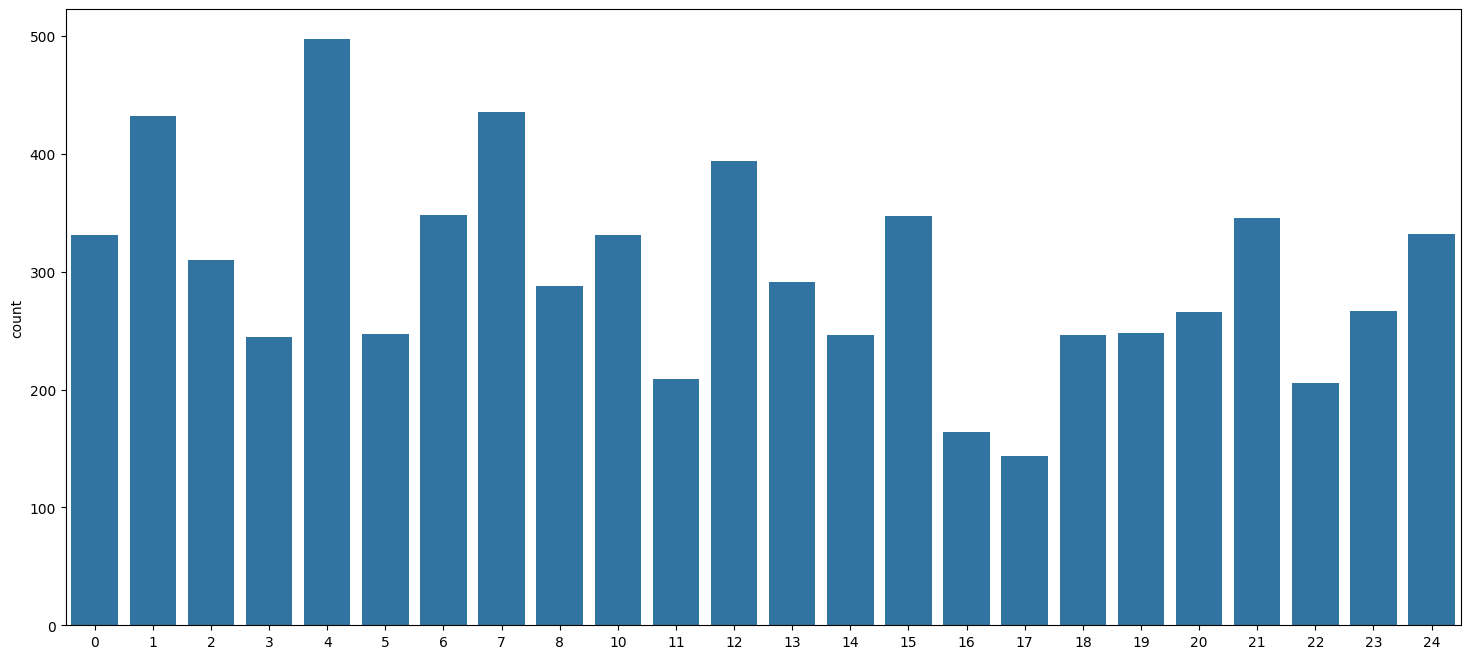

In [5]:
# Mostramos la cantidad de valores unicos, distribucion de clases
plt.figure(figsize = (18,8))
sns.countplot(x =labels)

In [6]:
# El dataset contiene imágenes en forma de vectores lineales de 784 elementos. 
# Reforma temporalmente los vectores en matrices 28x28 

train.drop('label', axis = 1, inplace = True)
images = train.values
images = np.array([np.reshape(i, (28, 28)) for i in images])
images = np.array([i.flatten() for i in images])

# Conviertimos estas etiquetas categóricas en un formato binario. One Hot encoding
label_binrizer = LabelBinarizer()
labels = label_binrizer.fit_transform(labels)


### Preparacion de datos

In [7]:
# Dividir el conjunto de datos en un conjunto de entrenamiento y un conjunto de prueba
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.3, random_state=101)

# Configurar el tamaño del lote y el número de épocas para el entrenamiento
batch_size = 128
num_epochs = 100
num_classes = 24

kFolds = 10

# Normalizar los datos de entrenamiento y de prueba para escalar los valores de los píxeles entre 0 y 1
x_train = x_train / 255.0
x_test = x_test / 255.0

# Redimensionar las imágenes para la entrada al modelo
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

# Learning rate y weight decay
learning_rate = 0.0001
weight_decay = 0.0001 # Tecnica de regularizacion para evitar overfitting, penaliza los pesos grandes


In [8]:
# Función para crear el modelo CNN
def create_cnn_model(input_shape, num_classes):
    model = Sequential([
        Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(64, kernel_size=(3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(64, kernel_size=(3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.20),
        Dense(num_classes, activation='softmax')
    ])
    return model

In [9]:
def run_experiment(model, x, y, num_epochs, batch_size, learning_rate, weight_decay, n_classes):
    # Convertir a numpy arrays si son tensores de TensorFlow
    if isinstance(x, tf.Tensor):
        x = x.numpy()
    if isinstance(y, tf.Tensor):
        y = y.numpy()

    skf = StratifiedKFold(kFolds, shuffle=True, random_state=42)
    fold_var = 1
    all_metrics = []
    average_losses_per_epoch = []  # Lista para almacenar las pérdidas medias por época
    
    for train_index, val_index in skf.split(x, np.argmax(y, axis=1)):
        print(f"Starting Fold {fold_var}")

        x_train_fold, x_val_fold = x[train_index], x[val_index]
        y_train_fold, y_val_fold = y[train_index], y[val_index]

        optimizer = tfa.optimizers.AdamW(
            learning_rate=learning_rate, weight_decay=weight_decay
        )
        current_learning_rate = optimizer.learning_rate.numpy()
        print(f"Current learning rate: {current_learning_rate}")
        
        model.compile(
            optimizer=optimizer,
            loss=keras.losses.CategoricalCrossentropy(from_logits=True),
            metrics=[
                keras.metrics.CategoricalAccuracy(name="accuracy"),
                keras.metrics.TopKCategoricalAccuracy(5, name="top-5-accuracy"),
            ],
        )

        checkpoint_filepath = f"checkpoints/fold_{fold_var}"
        checkpoint_callback = keras.callbacks.ModelCheckpoint(
            checkpoint_filepath,
            monitor="val_accuracy",
            save_best_only=True,
            save_weights_only=True,
        )

        # Lista para almacenar las pérdidas por época
        losses_per_epoch = []

        accuracy = 0  # Asignar un valor predeterminado
        print(f"Starting Epoch {num_epochs}")
        for epoch in range(num_epochs):
            print(f"Epoch {epoch + 1}/{num_epochs}")

            # Training
            history_callback = model.fit(
                x=x_train_fold,
                y=y_train_fold,
                batch_size=batch_size,
                epochs=1,
                validation_data=(x_val_fold, y_val_fold),
                callbacks=[checkpoint_callback],
            )

            # Almacena la pérdida de la época actual
            losses_per_epoch.append(history_callback.history["loss"][0])

            # Imprime las métricas cada 50 épocas
            if (epoch + 1) % 50 == 0:
                _, accuracy, _ = model.evaluate(x_val_fold, y_val_fold, verbose=0)
                print(f"Metrics at Fold {fold_var}, Epoch {epoch + 1}: Accuracy={accuracy:.4f}")

        # Almacena la pérdida media por época para este fold
        average_loss = np.mean(losses_per_epoch)
        average_losses_per_epoch.append(average_loss)

        print(f"Training model in Fold {fold_var}...")

        print(f"Evaluating model on Fold {fold_var}...")
        model.load_weights(checkpoint_filepath)
        y_pred = model.predict(x_val_fold)
        y_true = y_val_fold

        # Asegúrate de que y_true es un arreglo unidimensional de etiquetas de clase
        # Si y_val_fold es one-hot encoded, convertirlo a etiquetas de clase
        y_true_classes = np.argmax(y_val_fold, axis=1) if y_val_fold.ndim > 1 else y_val_fold

        # Convierte las predicciones del modelo de probabilidades a etiquetas de clase
        y_pred_classes = np.argmax(y_pred, axis=1)

        # Binarizar y_true para cálculo multiclase de AUC
        y_true_binarized = label_binarize(y_true_classes, classes=range(n_classes))

        # Calcula métricas adicionales usando las etiquetas de clase
        auc = roc_auc_score(y_true_binarized, y_pred, multi_class="ovr")
        precision = precision_score(y_true_classes, y_pred_classes, average='macro')
        recall = recall_score(y_true_classes, y_pred_classes, average='macro')
        f1 = f1_score(y_true_classes, y_pred_classes, average='macro')
        mcc = matthews_corrcoef(y_true_classes, y_pred_classes)

        # Almacena las métricas y parámetros en la tabla
        metrics = {
            "fold": fold_var,
            "epoch": num_epochs,
            "learning_rate": learning_rate,  
            "accuracy": accuracy,
            "auc": auc,
            "precision": precision,
            "recall": recall,
            "f1_score": f1,
            "mcc": mcc,
        }
        all_metrics.append(metrics)

        print(f"Completed Fold {fold_var} with accuracy {accuracy}")

        fold_var += 1

    # Crea un DataFrame con las métricas y parámetros
    metrics_df = pd.DataFrame(all_metrics)
    best_model_metrics = metrics_df.loc[metrics_df['auc'].idxmax()]

    print("Average test accuracy across all folds:", metrics_df['accuracy'].mean())

    # Gráfica de la pérdida media por época
    plt.figure(figsize=(10, 6))
    plt.plot(average_losses_per_epoch, label='Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Average Loss')
    plt.title('Average Loss per Epoch')
    plt.legend()
    plt.show()

    return metrics_df, best_model_metrics





Starting Fold 1
Current learning rate: 9.999999747378752e-05
Starting Epoch 100
Epoch 1/100


c:\Users\inigu\anaconda3\envs\py311\Lib\site-packages\keras\src\backend.py:5575: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(



36/36 [==============================] - 7s 110ms/step - loss: 3.1741 - accuracy: 0.0467 - top-5-accuracy: 0.2229 - val_loss: 3.1684 - val_accuracy: 0.0598 - val_top-5-accuracy: 0.2689
Epoch 2/100
36/36 [==============================] - 2s 61ms/step - loss: 3.1645 - accuracy: 0.0609 - top-5-accuracy: 0.2745 - val_loss: 3.1572 - val_accuracy: 0.0598 - val_top-5-accuracy: 0.2729
Epoch 3/100
36/36 [==============================] - 2s 61ms/step - loss: 3.1505 - accuracy: 0.0781 - top-5-accuracy: 0.3072 - val_loss: 3.1396 - val_accuracy: 0.0956 - val_top-5-accuracy: 0.3327
Epoch 4/100
36/36 [==============================] - 2s 58ms/step - loss: 3.1311 - accuracy: 0.0863 - top-5-accuracy: 0.3353 - val_loss: 3.1159 - val_accuracy: 0.1056 - val_top-5-accuracy: 0.3546
Epoch 5/100
36/36 [==============================] - 2s 67ms/step - loss: 3.1037 - accuracy: 0.0916 - top-5-accuracy: 0.3743 - val_loss: 3.0792 - val_accuracy: 0.1195 - val_top-5-accuracy: 0.4243
Epoch 6/100
36/36 [===========

c:\Users\inigu\anaconda3\envs\py311\Lib\site-packages\keras\src\backend.py:5575: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


36/36 [==============================] - 6s 81ms/step - loss: 0.2597 - accuracy: 0.9427 - top-5-accuracy: 0.9996 - val_loss: 0.1809 - val_accuracy: 0.9841 - val_top-5-accuracy: 0.9980
Epoch 2/100
36/36 [==============================] - 2s 57ms/step - loss: 0.2517 - accuracy: 0.9473 - top-5-accuracy: 0.9993 - val_loss: 0.1784 - val_accuracy: 0.9841 - val_top-5-accuracy: 1.0000
Epoch 3/100
36/36 [==============================] - 2s 44ms/step - loss: 0.2506 - accuracy: 0.9458 - top-5-accuracy: 0.9996 - val_loss: 0.1789 - val_accuracy: 0.9841 - val_top-5-accuracy: 1.0000
Epoch 4/100
36/36 [==============================] - 1s 42ms/step - loss: 0.2457 - accuracy: 0.9495 - top-5-accuracy: 0.9993 - val_loss: 0.1750 - val_accuracy: 0.9781 - val_top-5-accuracy: 1.0000
Epoch 5/100
36/36 [==============================] - 2s 55ms/step - loss: 0.2355 - accuracy: 0.9535 - top-5-accuracy: 0.9991 - val_loss: 0.1669 - val_accuracy: 0.9861 - val_top-5-accuracy: 1.0000
Epoch 6/100
36/36 [=============

c:\Users\inigu\anaconda3\envs\py311\Lib\site-packages\keras\src\backend.py:5575: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


36/36 [==============================] - 6s 84ms/step - loss: 0.1113 - accuracy: 0.9874 - top-5-accuracy: 1.0000 - val_loss: 0.0579 - val_accuracy: 0.9980 - val_top-5-accuracy: 1.0000
Epoch 2/100
36/36 [==============================] - 2s 58ms/step - loss: 0.1090 - accuracy: 0.9841 - top-5-accuracy: 1.0000 - val_loss: 0.0544 - val_accuracy: 1.0000 - val_top-5-accuracy: 1.0000
Epoch 3/100
36/36 [==============================] - 2s 53ms/step - loss: 0.1099 - accuracy: 0.9847 - top-5-accuracy: 1.0000 - val_loss: 0.0530 - val_accuracy: 1.0000 - val_top-5-accuracy: 1.0000
Epoch 4/100
36/36 [==============================] - 2s 45ms/step - loss: 0.1047 - accuracy: 0.9852 - top-5-accuracy: 1.0000 - val_loss: 0.0544 - val_accuracy: 1.0000 - val_top-5-accuracy: 1.0000
Epoch 5/100
36/36 [==============================] - 1s 38ms/step - loss: 0.0998 - accuracy: 0.9869 - top-5-accuracy: 1.0000 - val_loss: 0.0544 - val_accuracy: 0.9980 - val_top-5-accuracy: 1.0000
Epoch 6/100
36/36 [=============

c:\Users\inigu\anaconda3\envs\py311\Lib\site-packages\keras\src\backend.py:5575: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


36/36 [==============================] - 6s 75ms/step - loss: 0.1109 - accuracy: 0.9847 - top-5-accuracy: 1.0000 - val_loss: 0.0459 - val_accuracy: 1.0000 - val_top-5-accuracy: 1.0000
Epoch 2/100
36/36 [==============================] - 2s 52ms/step - loss: 0.1082 - accuracy: 0.9854 - top-5-accuracy: 1.0000 - val_loss: 0.0485 - val_accuracy: 1.0000 - val_top-5-accuracy: 1.0000
Epoch 3/100
36/36 [==============================] - 2s 57ms/step - loss: 0.1012 - accuracy: 0.9869 - top-5-accuracy: 1.0000 - val_loss: 0.0446 - val_accuracy: 1.0000 - val_top-5-accuracy: 1.0000
Epoch 4/100
36/36 [==============================] - 2s 54ms/step - loss: 0.1001 - accuracy: 0.9854 - top-5-accuracy: 0.9998 - val_loss: 0.0439 - val_accuracy: 1.0000 - val_top-5-accuracy: 1.0000
Epoch 5/100
36/36 [==============================] - 2s 54ms/step - loss: 0.0988 - accuracy: 0.9898 - top-5-accuracy: 1.0000 - val_loss: 0.0426 - val_accuracy: 1.0000 - val_top-5-accuracy: 1.0000
Epoch 6/100
36/36 [=============

c:\Users\inigu\anaconda3\envs\py311\Lib\site-packages\keras\src\backend.py:5575: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


36/36 [==============================] - 5s 55ms/step - loss: 0.1087 - accuracy: 0.9838 - top-5-accuracy: 1.0000 - val_loss: 0.0530 - val_accuracy: 1.0000 - val_top-5-accuracy: 1.0000
Epoch 2/100
36/36 [==============================] - 2s 63ms/step - loss: 0.1019 - accuracy: 0.9876 - top-5-accuracy: 1.0000 - val_loss: 0.0494 - val_accuracy: 1.0000 - val_top-5-accuracy: 1.0000
Epoch 3/100
36/36 [==============================] - 2s 57ms/step - loss: 0.0975 - accuracy: 0.9852 - top-5-accuracy: 1.0000 - val_loss: 0.0551 - val_accuracy: 0.9980 - val_top-5-accuracy: 1.0000
Epoch 4/100
36/36 [==============================] - 2s 55ms/step - loss: 0.0951 - accuracy: 0.9878 - top-5-accuracy: 1.0000 - val_loss: 0.0570 - val_accuracy: 1.0000 - val_top-5-accuracy: 1.0000
Epoch 5/100
36/36 [==============================] - 2s 55ms/step - loss: 0.0964 - accuracy: 0.9858 - top-5-accuracy: 1.0000 - val_loss: 0.0494 - val_accuracy: 0.9980 - val_top-5-accuracy: 1.0000
Epoch 6/100
36/36 [=============

c:\Users\inigu\anaconda3\envs\py311\Lib\site-packages\keras\src\backend.py:5575: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


36/36 [==============================] - 2s 28ms/step - loss: 0.1082 - accuracy: 0.9847 - top-5-accuracy: 1.0000 - val_loss: 0.0612 - val_accuracy: 1.0000 - val_top-5-accuracy: 1.0000
Epoch 2/100
36/36 [==============================] - 1s 25ms/step - loss: 0.0985 - accuracy: 0.9872 - top-5-accuracy: 1.0000 - val_loss: 0.0594 - val_accuracy: 1.0000 - val_top-5-accuracy: 1.0000
Epoch 3/100
36/36 [==============================] - 1s 25ms/step - loss: 0.0981 - accuracy: 0.9887 - top-5-accuracy: 1.0000 - val_loss: 0.0557 - val_accuracy: 1.0000 - val_top-5-accuracy: 1.0000
Epoch 4/100
36/36 [==============================] - 1s 23ms/step - loss: 0.0937 - accuracy: 0.9889 - top-5-accuracy: 1.0000 - val_loss: 0.0554 - val_accuracy: 1.0000 - val_top-5-accuracy: 1.0000
Epoch 5/100
36/36 [==============================] - 1s 27ms/step - loss: 0.0935 - accuracy: 0.9898 - top-5-accuracy: 1.0000 - val_loss: 0.0540 - val_accuracy: 1.0000 - val_top-5-accuracy: 1.0000
Epoch 6/100
36/36 [=============

c:\Users\inigu\anaconda3\envs\py311\Lib\site-packages\keras\src\backend.py:5575: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


36/36 [==============================] - 7s 82ms/step - loss: 0.0424 - accuracy: 0.9978 - top-5-accuracy: 1.0000 - val_loss: 0.0174 - val_accuracy: 1.0000 - val_top-5-accuracy: 1.0000
Epoch 2/100
36/36 [==============================] - 2s 57ms/step - loss: 0.0369 - accuracy: 0.9982 - top-5-accuracy: 1.0000 - val_loss: 0.0165 - val_accuracy: 1.0000 - val_top-5-accuracy: 1.0000
Epoch 3/100
36/36 [==============================] - 1s 41ms/step - loss: 0.0355 - accuracy: 0.9989 - top-5-accuracy: 1.0000 - val_loss: 0.0170 - val_accuracy: 1.0000 - val_top-5-accuracy: 1.0000
Epoch 4/100
36/36 [==============================] - 2s 52ms/step - loss: 0.0366 - accuracy: 0.9982 - top-5-accuracy: 1.0000 - val_loss: 0.0172 - val_accuracy: 1.0000 - val_top-5-accuracy: 1.0000
Epoch 5/100
36/36 [==============================] - 2s 54ms/step - loss: 0.0338 - accuracy: 0.9985 - top-5-accuracy: 1.0000 - val_loss: 0.0154 - val_accuracy: 1.0000 - val_top-5-accuracy: 1.0000
Epoch 6/100
36/36 [=============

c:\Users\inigu\anaconda3\envs\py311\Lib\site-packages\keras\src\backend.py:5575: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


36/36 [==============================] - 5s 71ms/step - loss: 0.0398 - accuracy: 0.9987 - top-5-accuracy: 1.0000 - val_loss: 0.0191 - val_accuracy: 1.0000 - val_top-5-accuracy: 1.0000
Epoch 2/100
36/36 [==============================] - 2s 45ms/step - loss: 0.0352 - accuracy: 0.9987 - top-5-accuracy: 1.0000 - val_loss: 0.0177 - val_accuracy: 1.0000 - val_top-5-accuracy: 1.0000
Epoch 3/100
36/36 [==============================] - 1s 40ms/step - loss: 0.0352 - accuracy: 0.9985 - top-5-accuracy: 1.0000 - val_loss: 0.0171 - val_accuracy: 1.0000 - val_top-5-accuracy: 1.0000
Epoch 4/100
36/36 [==============================] - 1s 40ms/step - loss: 0.0360 - accuracy: 0.9989 - top-5-accuracy: 1.0000 - val_loss: 0.0183 - val_accuracy: 1.0000 - val_top-5-accuracy: 1.0000
Epoch 5/100
36/36 [==============================] - 1s 40ms/step - loss: 0.0344 - accuracy: 0.9985 - top-5-accuracy: 1.0000 - val_loss: 0.0177 - val_accuracy: 1.0000 - val_top-5-accuracy: 1.0000
Epoch 6/100
36/36 [=============

c:\Users\inigu\anaconda3\envs\py311\Lib\site-packages\keras\src\backend.py:5575: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


36/36 [==============================] - 4s 56ms/step - loss: 0.0394 - accuracy: 0.9967 - top-5-accuracy: 1.0000 - val_loss: 0.0160 - val_accuracy: 1.0000 - val_top-5-accuracy: 1.0000
Epoch 2/100
36/36 [==============================] - 2s 44ms/step - loss: 0.0387 - accuracy: 0.9985 - top-5-accuracy: 1.0000 - val_loss: 0.0170 - val_accuracy: 1.0000 - val_top-5-accuracy: 1.0000
Epoch 3/100
36/36 [==============================] - 1s 41ms/step - loss: 0.0365 - accuracy: 0.9973 - top-5-accuracy: 1.0000 - val_loss: 0.0157 - val_accuracy: 1.0000 - val_top-5-accuracy: 1.0000
Epoch 4/100
36/36 [==============================] - 1s 40ms/step - loss: 0.0357 - accuracy: 0.9987 - top-5-accuracy: 1.0000 - val_loss: 0.0166 - val_accuracy: 1.0000 - val_top-5-accuracy: 1.0000
Epoch 5/100
36/36 [==============================] - 1s 38ms/step - loss: 0.0349 - accuracy: 0.9978 - top-5-accuracy: 1.0000 - val_loss: 0.0170 - val_accuracy: 1.0000 - val_top-5-accuracy: 1.0000
Epoch 6/100
36/36 [=============

c:\Users\inigu\anaconda3\envs\py311\Lib\site-packages\keras\src\backend.py:5575: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


36/36 [==============================] - 3s 46ms/step - loss: 0.0379 - accuracy: 0.9982 - top-5-accuracy: 1.0000 - val_loss: 0.0145 - val_accuracy: 1.0000 - val_top-5-accuracy: 1.0000
Epoch 2/100
36/36 [==============================] - 1s 34ms/step - loss: 0.0369 - accuracy: 0.9982 - top-5-accuracy: 1.0000 - val_loss: 0.0144 - val_accuracy: 1.0000 - val_top-5-accuracy: 1.0000
Epoch 3/100
36/36 [==============================] - 1s 37ms/step - loss: 0.0371 - accuracy: 0.9980 - top-5-accuracy: 1.0000 - val_loss: 0.0158 - val_accuracy: 1.0000 - val_top-5-accuracy: 1.0000
Epoch 4/100
36/36 [==============================] - 1s 38ms/step - loss: 0.0346 - accuracy: 0.9987 - top-5-accuracy: 1.0000 - val_loss: 0.0146 - val_accuracy: 1.0000 - val_top-5-accuracy: 1.0000
Epoch 5/100
36/36 [==============================] - 1s 36ms/step - loss: 0.0371 - accuracy: 0.9980 - top-5-accuracy: 1.0000 - val_loss: 0.0147 - val_accuracy: 1.0000 - val_top-5-accuracy: 1.0000
Epoch 6/100
36/36 [=============

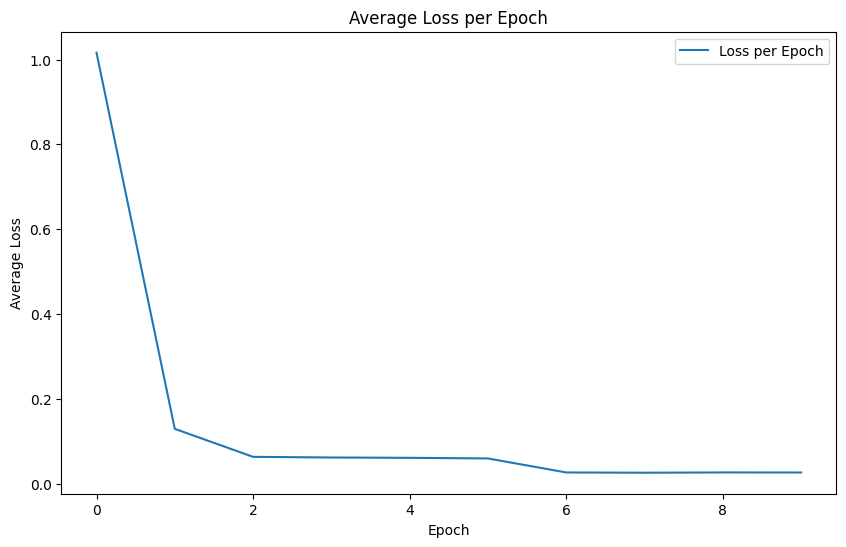

In [10]:
model = create_cnn_model((28, 28, 1), num_classes)
history, best_history = run_experiment(model, x_train, y_train, num_epochs, batch_size, learning_rate, weight_decay, num_classes)

In [11]:
# Configurar el formato de impresión
pd.set_option('display.max_columns', None)  # Mostrar todas las columnas
pd.set_option('display.expand_frame_repr', False)  # Evitar que las columnas se ajusten automáticamente
pd.set_option('display.float_format', '{:.4f}'.format)  # Formato de los números de punto flotante

# Imprimir los datos
print("All Metrics:")
print(history)

print("\nBest Model Metrics:")
print(best_history)


All Metrics:
   fold  epoch  learning_rate  accuracy    auc  precision  recall  f1_score    mcc
0     1    100         0.0001    0.9761 0.9999     0.9794  0.9767    0.9766 0.9772
1     2    100         0.0001    1.0000 1.0000     1.0000  1.0000    1.0000 1.0000
2     3    100         0.0001    1.0000 1.0000     1.0000  1.0000    1.0000 1.0000
3     4    100         0.0001    1.0000 1.0000     1.0000  1.0000    1.0000 1.0000
4     5    100         0.0001    1.0000 1.0000     1.0000  1.0000    1.0000 1.0000
5     6    100         0.0001    1.0000 1.0000     1.0000  1.0000    1.0000 1.0000
6     7    100         0.0001    1.0000 1.0000     1.0000  1.0000    1.0000 1.0000
7     8    100         0.0001    1.0000 1.0000     1.0000  1.0000    1.0000 1.0000
8     9    100         0.0001    1.0000 1.0000     1.0000  1.0000    1.0000 1.0000
9    10    100         0.0001    1.0000 1.0000     1.0000  1.0000    1.0000 1.0000

Best Model Metrics:
fold              3.0000
epoch           100.0000
lea

In [12]:
best_auc_model = history.loc[history['auc'].idxmax()]
best_model_path = f"checkpoints/fold_{int(best_auc_model['fold'])}"  # Convertir el número de fold a entero


print(best_auc_model)
print(best_model_path)


fold              3.0000
epoch           100.0000
learning_rate     0.0001
accuracy          1.0000
auc               1.0000
precision         1.0000
recall            1.0000
f1_score          1.0000
mcc               1.0000
Name: 2, dtype: float64
checkpoints/fold_3


In [13]:
best_model = create_cnn_model((28, 28, 1), num_classes)
best_model.load_weights(best_model_path)
best_model.save('mi_modelo2.keras')

68/68 [==============================] - 1s 7ms/step


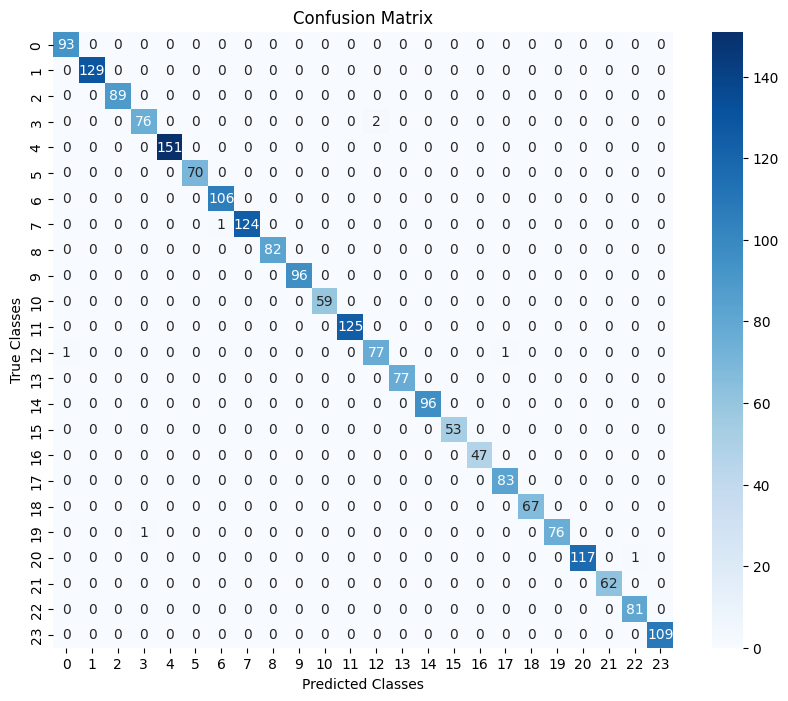

In [14]:
y_pred = best_model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert one-hot encoded y_test to integer class labels
y_test_classes = np.argmax(y_test, axis=1)

# Now, create the confusion matrix
conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)

# Visualize the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Classes')
plt.ylabel('True Classes')
plt.show()



22/68 [========>.....................] - ETA: 0s

68/68 [==============================] - 1s 6ms/step


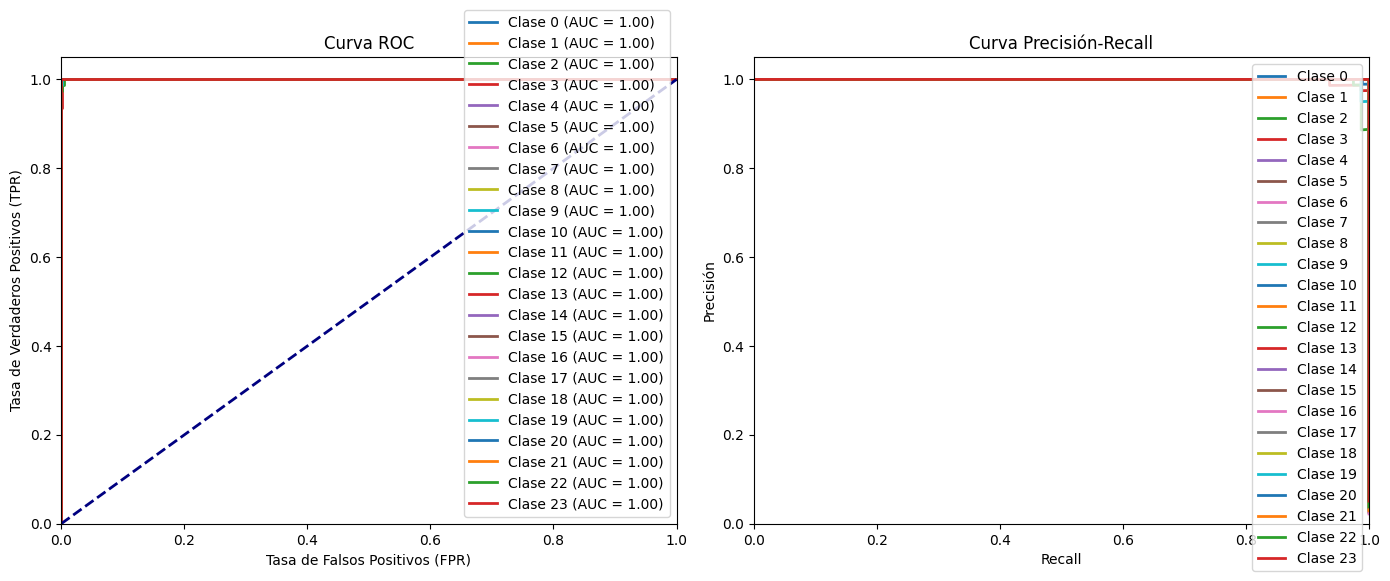

In [15]:
# Obtener las probabilidades de predicción del modelo en el conjunto de prueba
y_test_probs = best_model.predict(x_test)

# Binarizar las etiquetas verdaderas para cálculo multiclase de AUC
y_test_binarized = label_binarize(y_test, classes=range(num_classes))

# Inicializar la figura para los subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot AUC-ROC
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_test_probs[:, i])
    roc_auc = auc(fpr, tpr)
    axes[0].plot(fpr, tpr, lw=2, label=f'Clase {i} (AUC = {roc_auc:.2f})')

axes[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[0].set_xlim([0.0, 1.0])
axes[0].set_ylim([0.0, 1.05])
axes[0].set_xlabel('Tasa de Falsos Positivos (FPR)')
axes[0].set_ylabel('Tasa de Verdaderos Positivos (TPR)')
axes[0].set_title('Curva ROC')
axes[0].legend(loc="lower right")

# Plot Precisión vs. Recall
for i in range(num_classes):
    precision, recall, _ = precision_recall_curve(y_test_binarized[:, i], y_test_probs[:, i])
    axes[1].plot(recall, precision, lw=2, label=f'Clase {i}')

axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precisión')
axes[1].set_title('Curva Precisión-Recall')
axes[1].legend(loc="upper right")
plt.tight_layout()
plt.show()

In [17]:
import cv2
import numpy as np
from keras.models import load_model


# Crear un diccionario para mapear índices numéricos a letras
alphabet = 'ABCDEFGHIKLMNOPQRSTUVWXY'  # Excluye J y Z
index_to_letter = {i: alphabet[i] for i in range(len(alphabet))}

# Carga tu modelo entrenado
#modelCV = load_model('mi_modelo.keras', custom_objects={'Patches': Patches})
modelCV = load_model('mi_modelo2.keras')

# Inicia la captura de video
cap = cv2.VideoCapture(0)

# Inicializa la variable para la letra predicha y la imagen capturada
predicted_letter = None
captured_frame = None

while True:
    # Captura fotograma a fotograma
    ret, frame = cap.read()
    if not ret:
        break

    # Si hay una imagen capturada, utiliza esa imagen en lugar del fotograma en vivo
    if captured_frame is not None:
        frame = captured_frame

    # Si hay una letra predicha, muestra el resultado como texto en la ventana
    if predicted_letter is not None:
        cv2.putText(frame, f"Letra Predicha: {predicted_letter}", (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

    # Opcional: muestra la imagen en una ventana
    cv2.imshow('Video', frame)

    # Espera la entrada del usuario
    key = cv2.waitKey(1) & 0xFF

    # Si se presiona 'c', captura el fotograma actual
    if key == ord('c'):
        captured_frame = frame.copy()
        processed_frame = cv2.cvtColor(captured_frame, cv2.COLOR_BGR2GRAY)
        processed_frame = cv2.resize(processed_frame, (28, 28))
        processed_frame = processed_frame.astype('float32') / 255
        processed_frame = np.reshape(processed_frame, (1, 28, 28, 1))
        prediction = modelCV.predict(processed_frame)
        letter_index = np.argmax(prediction)
        predicted_letter = index_to_letter[letter_index]
        print("Letra Predicha:", predicted_letter)

    # Si se presiona 'r', reinicia el proceso
    elif key == ord('r'):
        predicted_letter = None
        captured_frame = None

    # Salir con 'q'
    elif key == ord('q'):
        break

# Libera la cámara y cierra las ventanas abiertas
cap.release()
cv2.destroyAllWindows()


1/1 [==============================] - 0s 97ms/step
Letra Predicha: L
1/1 [==============================] - 0s 20ms/step
Letra Predicha: H
1/1 [==============================] - 0s 22ms/step
Letra Predicha: H
1/1 [==============================] - 0s 18ms/step
Letra Predicha: T
1/1 [==============================] - 0s 18ms/step
Letra Predicha: H
1/1 [==============================] - 0s 20ms/step
Letra Predicha: H
1/1 [==============================] - 0s 20ms/step
Letra Predicha: Y
1/1 [==============================] - 0s 18ms/step
Letra Predicha: H
1/1 [==============================] - 0s 17ms/step
Letra Predicha: C
1/1 [==============================] - 0s 20ms/step
Letra Predicha: C
1/1 [==============================] - 0s 19ms/step
Letra Predicha: O
1/1 [==============================] - 0s 20ms/step
Letra Predicha: C
1/1 [==============================] - 0s 21ms/step
Letra Predicha: P
1/1 [==============================] - 0s 21ms/step
Letra Predicha: L
1/1 [===============